# Make Your Own Regression Model Challenge

In [202]:
import math
import warnings

from IPython.display import display
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn import linear_model
import statsmodels.formula.api as smf
import scipy.stats
import statsmodels.formula.api as smf
from statsmodels.sandbox.regression.predstd import wls_prediction_std
import math

%matplotlib inline
sns.set_style('white')

# Display preferences.
%matplotlib inline
pd.options.display.float_format = '{:.3f}'.format

# Suppress annoying harmless error.
warnings.filterwarnings(
    action="ignore",
    module="scipy",
    message="^internal gelsd"
)

## Preparing data

### Read in data


In [290]:
#Read in data
df = pd.read_csv('crime.csv')

#Rename columns
df.columns = ['city','population','violent_crime','murder_nonegligent_manslaughter','rape_revised','rape_legacy_def','robbery','agg_assault','property_crime','burglary','larceny_theft','motor_theft','arson3','unnamed']

In [291]:
#df2 = df[['population','violent_crime','murder_nonegligent_manslaughter','rape_legacy_def','robbery','agg_assault','property_crime','burglary','larceny_theft','motor_theft']].copy()

#df2 = df[['robbery','property_crime','population','murder_nonegligent_manslaughter']].copy()

df.drop(['rape_revised','unnamed','arson3','city'],axis=1,inplace=True)

df2 = df.copy()

In [292]:
#Preview data
df2.head(5)

,population,violent_crime,murder_nonegligent_manslaughter,rape_legacy_def,robbery,agg_assault,property_crime,burglary,larceny_theft,motor_theft
0,"1,861",0,0.000,0,0,0,12,2,10,0
1,"2,577",3,0.000,0,0,3,24,3,20,1
2,"2,846",3,0.000,0,0,3,16,1,15,0
3,"97,956",791,8.000,30,227,526,"4,090",705,"3,243",142
4,"6,388",23,0.000,3,4,16,223,53,165,5


### Clean data

During this phase, we eliminate na values, remove commas, convert numeric data to numeric data type and winsorize to account for outlieres.

In [293]:
#Evaluate how many null values there are 
df2.isnull().sum()

population                         3
violent_crime                      3
murder_nonegligent_manslaughter    3
rape_legacy_def                    3
robbery                            3
agg_assault                        3
property_crime                     3
burglary                           3
larceny_theft                      3
motor_theft                        3
dtype: int64

In [294]:
#There aren't that many null values so instead of imputing, we'll just remove them
df2 = df2.dropna()

In [295]:
#Evaluate data types; we need to convert some of the objects to floats
df2.dtypes

population                          object
violent_crime                       object
murder_nonegligent_manslaughter    float64
rape_legacy_def                     object
robbery                             object
agg_assault                         object
property_crime                      object
burglary                            object
larceny_theft                       object
motor_theft                         object
dtype: object

In [296]:
cols = ['population','violent_crime','murder_nonegligent_manslaughter','rape_legacy_def','robbery','agg_assault','property_crime','burglary','larceny_theft','motor_theft']

df2[cols] = df2[cols].replace({',':''},regex=True)

In [297]:
df2 = df2.apply(pd.to_numeric,errors='coerce')

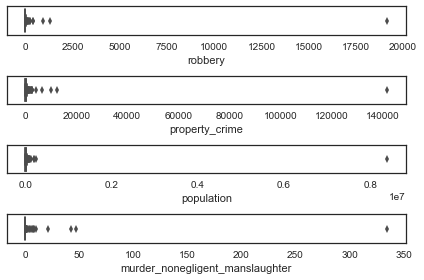

In [298]:
#Evalute distribution of data
fig, axs = plt.subplots(nrows=4)
sns.boxplot(df2['robbery'],ax=axs[0])
sns.boxplot(df2['property_crime'],ax=axs[1])
sns.boxplot(df2['population'],ax=axs[2])
sns.boxplot(df2['murder_nonegligent_manslaughter'],ax=axs[3])
plt.tight_layout()


In [299]:
#There appear to be some pretty outstanding outliers,
#we'll winsorize the data so they don't impair the model's performance 
for column in df2:
    df2[column] = scipy.stats.mstats.winsorize(df2[column],limits=[0.05,0.05])

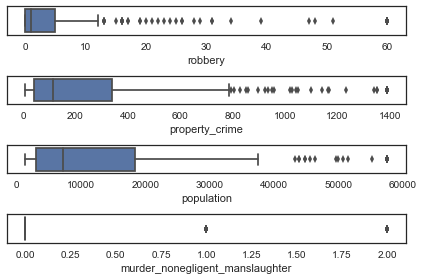

In [300]:
#Revaluate distribution of data after winsorizing
fig, axs = plt.subplots(nrows=4)
sns.boxplot(df2['robbery'],ax=axs[0])
sns.boxplot(df2['property_crime'],ax=axs[1])
sns.boxplot(df2['population'],ax=axs[2])
sns.boxplot(df2['murder_nonegligent_manslaughter'],ax=axs[3])
plt.tight_layout()

### Engineer new features

The features engineered here are the requisite engineered features from the previous exercise. For the purpose of this exercise, we'll continue to utilize the data set with these engineered features. 

In [301]:
#Whether robbery occurred in the city or not 
df2['robbery_signal'] = np.where((df2['robbery'] > 0),1,0)

#Whether murder occurred in the city or not 
df2['murder_signal'] = np.where((df2['murder_nonegligent_manslaughter'] > 0),1,0)

### Select Features

During this phase, we'll be using mutual_info_classif to select the top 3 attributes to run the linear model through. 

In [439]:
from sklearn.feature_selection import SelectKBest, mutual_info_classif

features = df2.drop('property_crime',axis=1)
target = df2['property_crime']

selector = SelectKBest(mutual_info_classif,k=3)

selector.fit(features, target)

idxs_selected = selector.get_support(indices=True)
result = features[features.columns[[idxs_selected]]]

In [440]:
result.head()

,burglary,larceny_theft,property_crime_bc
0,2,10,2.567
1,3,20,3.313
2,1,15,2.875
3,224,1182,7.965
4,53,165,5.807


In [107]:
df2['property_crime_bc'] = scipy.stats.boxcox(df2['property_crime'])[0]
df2['larceny_theft_bc'] = scipy.stats.boxcox(df2['larceny_theft'])[0]

In [420]:
df2['property_crime_bc'] = scipy.stats.boxcox(df2['property_crime'])[0]

## Model

### Run regression

The R-squared value is quite high which suggests that the model is overfitting. Let's investigate further. 

In [444]:
#Instantiate and fit model
regr = linear_model.LinearRegression()
Y = df2['property_crime']
X = df2[['population','violent_crime','robbery','agg_assault','burglary','motor_theft','robbery_signal']]
regr.fit(X, Y)

#Inspect results
print('\nCoefficients: \n', regr.coef_)
print('\nIntercept: \n', regr.intercept_)
print('\nR-squared:')
print(regr.score(X, Y))


Coefficients: 
 [  7.38815849e-03   3.18094852e+00  -4.67850356e+00  -3.02865033e+00
   3.69688660e+00   3.59806436e+00   2.92003317e+01]

Intercept: 
 -20.093381288

R-squared:
0.92521154364


### Cross validate

In [445]:
#Initialize standardizer, pipeline and KFold. Also standardize data during cross validation.
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import KFold, cross_val_score

standardizer = StandardScaler()
pipeline = make_pipeline(standardizer, regr)
kf = KFold(n_splits=10, shuffle=True, random_state=1)

In [446]:
#Append results of crossvalidation to cv_results
cv_results = cross_val_score(pipeline, 
                             X, 
                             Y, 
                             cv=kf, 
                             n_jobs=-1)


In [447]:
cv_results.mean()

0.91078311359996533

## Evaluate

### Normality Assessment

The distribution of residuals is slightly skewed. 

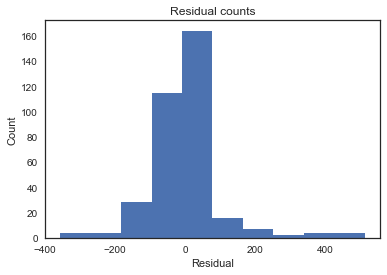

In [448]:
# Extract predicted values.
predicted = regr.predict(X).ravel()
actual = df2['property_crime'].astype(float)

# Calculate the error, also called the residual.
residual = actual - predicted

# This looks a bit concerning.
plt.hist(residual)
plt.title('Residual counts')
plt.xlabel('Residual')
plt.ylabel('Count')
plt.show()

### Scedasticity Assessment

Based on the scedasticity plot, the model appears to perform reasonably well for low value predictions, however performance drops considerably for moderate to high value predictions. 

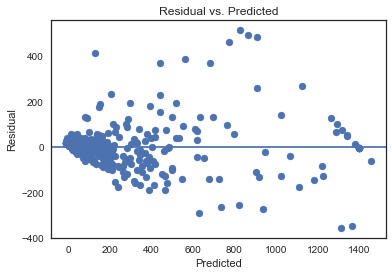

In [449]:
plt.scatter(predicted, residual)
plt.xlabel('Predicted')
plt.ylabel('Residual')
plt.axhline(y=0)
plt.title('Residual vs. Predicted')
plt.show()

### Linear Relationships Assessment

The relationship between the attributes and target variable appear to be more or less linear and thus do not require any sort of nonlinear transformation.

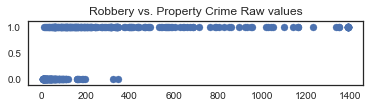

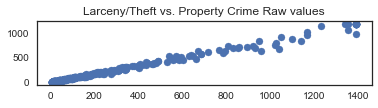

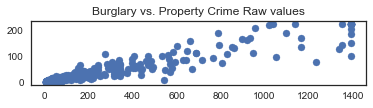

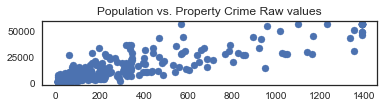

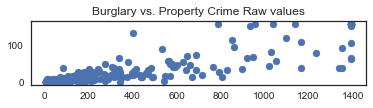

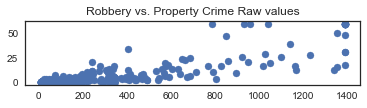

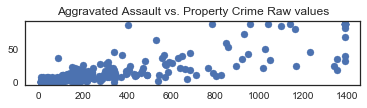

In [453]:
plt.subplot(3,1,1)
plt.scatter(df2['property_crime'], df2['robbery_signal'])
plt.title('Robbery vs. Property Crime Raw values')
plt.show()

plt.subplot(3,1,2)
plt.scatter(df2['property_crime'], df2['larceny_theft'])
plt.title('Larceny/Theft vs. Property Crime Raw values')
plt.show()

plt.subplot(3,1,3)
plt.scatter(df2['property_crime'], df2['burglary'])
plt.title('Burglary vs. Property Crime Raw values')
plt.show()

plt.subplot(3,1,3)
plt.scatter(df2['property_crime'], df2['population'])
plt.title('Population vs. Property Crime Raw values')
plt.show()

plt.subplot(3,1,3)
plt.scatter(df2['property_crime'], df2['violent_crime'])
plt.title('Burglary vs. Property Crime Raw values')
plt.show()

plt.subplot(3,1,3)
plt.scatter(df2['property_crime'], df2['robbery'])
plt.title('Robbery vs. Property Crime Raw values')
plt.show()

plt.subplot(3,1,3)
plt.scatter(df2['property_crime'], df2['agg_assault'])
plt.title('Aggravated Assault vs. Property Crime Raw values')
plt.show()

### Collinearity Assessment

There's a lot of multicollinearity which is not ideal for the model.

In [410]:
correlation_matrix = X.corr()
display(correlation_matrix)

,population,violent_crime,robbery,agg_assault,burglary,motor_theft,robbery_signal
population,1.000,0.808,0.801,0.794,0.851,0.844,0.483
violent_crime,0.808,1.000,0.968,0.990,0.913,0.891,0.410
robbery,0.801,0.968,1.000,0.928,0.898,0.902,0.389
agg_assault,0.794,0.990,0.928,1.000,0.894,0.863,0.407
burglary,0.851,0.913,0.898,0.894,1.000,0.893,0.477
motor_theft,0.844,0.891,0.902,0.863,0.893,1.000,0.400
robbery_signal,0.483,0.410,0.389,0.407,0.477,0.400,1.000
